This example is created by *Shuvashish Mondal* with help from *Shammah Lilonfe, Stephen Cini, Joe Jackson, Dr. Daniel Laky, and Dr. Alexander Dowling* using the data and the equation from *"Nonlinear Regression Analysis and Its Applications - 1988 - Bates"* p.33 Example. This example below implements `parmest`, and `scipy` for parameter estimation, `DOE`for full factorial design and covarianve matrix caluculation and compare the parameter estimation and covariance matrix esitmated from `DOE` and `Parmest` with `scipy` and `Monte Carlo`.

**Equation:**  
    $$f(x, \theta) = \frac{\theta_1x}{\theta_2 + x}$$  
where,  
$\qquad f(x, \theta)\rightarrow$ reaction velocity (response / output variable)  
$\qquad \theta_1, \theta_2 \rightarrow$ parameters  
$\qquad x\rightarrow$ substrate concentration (control / decision variable)  

**Data:**  
<table>
  <thead>
    <tr>
      <th>Substrate</th>
      <th colspan="2">Velocity</th>
    </tr>
    <tr>
      <th>Concentration</th>
      <th colspan="2">(counts/min<sup>2</sup>)</th>
    </tr>
    <tr>
      <th>(ppm)</th>
      <th>(a) Treated</th>
      <th>(b) Untreated</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.02</td>
      <td style="vertical-align: top; text-align: center;">76 <br> 47</td>
      <td style="vertical-align: top; text-align: center;">67 <br> 51</td>
    </tr>
    <tr>
      <td>0.06</td>
      <td style="vertical-align: top; text-align: center;">97 <br> 107</td>
      <td style="vertical-align: top; text-align: center;">84 <br> 86</td>
    </tr>
    <tr>
      <td>0.11</td>
      <td style="vertical-align: top; text-align: center;">123 <br> 139</td>
      <td style="vertical-align: top; text-align: center;">98 <br> 115</td>
    </tr>
    <tr>
      <td>0.22</td>
      <td style="vertical-align: top; text-align: center;">159 <br> 152</td>
      <td style="vertical-align: top; text-align: center;">131 <br> 124</td>
    </tr>
    <tr>
      <td>0.56</td>
      <td style="vertical-align: top; text-align: center;">191 <br> 201</td>
      <td style="vertical-align: top; text-align: center;">144 <br> 158</td>
    </tr>
    <tr>
      <td>1.10</td>
      <td style="vertical-align: top; text-align: center;">207 <br> 200</td>
      <td style="vertical-align: top; text-align: center;">160</td>
    </tr>
  </tbody>
</table>

In the table we have two different velocity data: treated and untreated, for each observation of substrate data. We will take the average of the two data for each observation for each type of velocity, and then calculate our parameters with that averagae data.

# Importing packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.contrib.parmest import parmest # import parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
import pandas as pd
from itertools import product

# Generate Data

In [3]:
theta_true = [212.71, 0.0645]  # True parameter values

In [4]:
# Generate Data
def michaelis_menten_model_data(x, theta=theta_true):
    np.random.seed(42)
    """
    Michaelis-Menten model function to generate data.
    Vmax, Km = theta
    x: substrate concentration. ppm
    -----------------------------------------
    Returns the reaction rate. counts/min^2
    """
    Vmax, Km = theta
    f = (Vmax * x) / (Km + x)+np.random.normal(0, 5)  # Adding some noise
    return f

In [81]:
subs_conc = np.array([0.02, 0.06])
rxn_rate = michaelis_menten_model_data(subs_conc)
rxn_rate

array([ 52.83, 104.99])

In [82]:
# substrate_concentration = [0.02, 0.06, 0.11, 0.22, 0.56, 1.10]

# treated_velocity = [[76, 47], [97, 107], [123, 139], [159, 152], [191, 201], [207, 200]]

In [83]:
# Organizing the data in a ``list`` consisting of ``dict``s of ``one key : one value``
data_treated = [
    {"substrate_concentration" : sc, "avg_velocity": rr} for sc, rr in zip(subs_conc, rxn_rate)
]

In [84]:
data_treated

[{'substrate_concentration': np.float64(0.02),
  'avg_velocity': np.float64(52.82913289523368)},
 {'substrate_concentration': np.float64(0.06),
  'avg_velocity': np.float64(104.99441413855014)}]

# PARMEST & DOE

## Creating an experiment class for both DOE and ParmEst
We will use this class for both parmest (to estimate the parameters) and DOE (To calculate the FIM and factorial design)

In [85]:
class ReactionVelocity(Experiment):

    # Defining the constructor for our model
    def __init__(self, data, theta_initial=None, scale_params=True):
        """
        Arguments:
            data: data from our experiment. type: 'dict'
            theta_initial: initial guess of the parameter values, dtype: dict. pass the values as theta_initial = {1 : <theta_1 initial value>, 2 : <theta_2 initial value>}
                default:  {1: 100, 2: 0.05}
                
        """
        self.conc = data["substrate_concentration"]
        self.vel = data["avg_velocity"]
        self.model = None
        self.theta_initial = theta_initial
        if self.theta_initial is None:
            self.theta_initial = {1: 100, 2: 0.02}  # default initial guess of theta[1] & theta[2]
        else:
            self.theta_initial = theta_initial

        if scale_params:
            self.theta_1_scale = 200
            self.theta_2_scale = 0.050
        else:
            self.theta_1_scale = 1
            self.theta_2_scale = 1

    # Creating the get_labeled_model which is a must for ``DOE`` and ``ParmEst``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
            self.finalize_model()
        return self.model

    
    def create_model(self):
        """
        Here, we will create different variables, parameters, and constraints
        """
        m = self.model = pyo.ConcreteModel()

        # theta_1
        m.theta_1 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.theta_initial[1])
        m.theta_2 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.theta_initial[2])

        # substrate concentration (x) as a param, since the data is given          
        m.x = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.conc)
        m.reaction_velocity = pyo.Var(domain = pyo.NonNegativeReals)
       
        @m.Constraint()  # since the ``Constraint`` is not a set of anything, so there is no argument
        def vel_con(m):
            return m.reaction_velocity == m.theta_1 * self.theta_1_scale * m.x / (self.theta_2_scale*m.theta_2 + m.x)

        # ======================================
        # Objective function
        """
        For some reason the``obj_function = "SSE"``in parmest ``Estimator`` does not work for LR ratio.
        That's why I have created the ``Total_Cost_Obj`` to minimize the SSE. You can ignore this and use default "SSE". 
        Both ``FirstStageCost`` and ``SecondStageCost`` are required for the ``Objective``, otherwise it will show ``AttributeError``
        """
        
        # # Stage-specific cost computation
        # m.FirstStageCost = pyo.Expression(initialize = 0)
        # m.SecondStageCost = pyo.Expression(expr = (self.vel - m.reaction_velocity) ** 2)

        # m.Total_Cost_Obj = pyo.Objective(expr = (m.FirstStageCost + m.SecondStageCost), sense = pyo.minimize)
        # # ======================================

            
        # m.pprint()
        
        return m

    
    def finalize_model(self):
        """
        Finalizing the model. Here, we will set the experimental conditions (e.g, initial conditions),
        fixing the parameter values (if needed), update `t` values, and discretize the model (if model is dynamic). 
        It makes a solvable model.
        """        
        m=self.model

        # fixing the parameters
        m.theta_1.fix(self.theta_initial[1]) 
        m.theta_2.fix(self.theta_initial[2]) 

        # Add lower and upper bound to substrate concentration (control variable)
        m.x.setlb(0)
        m.x.setub(20)

        # fixing the substrate concentration (control variable)
        m.x.fix(self.conc)

        return m

    
    def label_model(self):
        """
        The model is updated with outputs, and unknown parameters. This makes the model labeled with full experiment.
        In `ParmEst` output (given data) is the most important. For `DOE` input is most important.
        """
        m = self.model

        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)  
        m.experiment_outputs.update([(m.reaction_velocity, self.vel)])  # Pass the data as a list of `tuple`
        # If we only use ``DOE``, we could use ``m.experiment_ouputs.update([(m.x, None)])``.
        # Output is not important for ``DOE``

        m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)    
        # m.experiment_inputs[m.x] = self.conc
        m.experiment_inputs.update([(m.x, self.conc)])
        # If we only use ``DOE``, we could use ``m.experiment_inputs.update([(m.x, None)])``

        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.theta_1, m.theta_2])
        # m.unknown_parameters[m.theta_1]= self.theta_initial[1]
        # m.unknown_parameters[m.theta_2]= self.theta_initial[2]

        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # m.measurement_error[m.reaction_velocity] = 5
        m.measurement_error.update([(m.reaction_velocity, 5)]) 

        return m

# RUN 1
## Parmest Example
We will evaluate diffent parameters, visualize pairwise plots and show bootstrap table

### Treated velocity
Here, we will calculate objective value at optimum parameter value, paramater values, $\theta$, and covariance matrix for treated velocity.

In [86]:
exp_list = []  # list to hold each experiment
n_exp = len(data_treated)

# exp_list to separate each experiment
for i in range(n_exp):
    exp_list.append(ReactionVelocity(data_treated[i],))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, obj_function="SSE", tee = True)

# Estimating d
obj, theta = pest.theta_est()

# ``parmest`` can mess up the order of the theta estimates and also the covariance. So we need to fix the order so that we can manipulate it properly.
t_order = ["theta_1", "theta_2"]
theta_perm = theta.loc[t_order]  # ``theta`` in the order we want

print("\ntheta values:")
print(theta_perm)

print("\nSSE value: ", obj)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

## DOE

In [87]:
theta_initial = {1: theta_perm["theta_1"], 2: theta_perm["theta_2"]}
data = data_treated

In [88]:
def run_reactor_doe(data, n_exp, theta_initial):
    """
    Argument:
    design_ranges: a `list`. [start, stop, number_of_points]. This argument is required for full factorial design.
    """
    FIM = []
    for i in range(n_exp):
        # Create a ReactorVelocity object for each experiment
        experiment = ReactionVelocity(data[i], theta_initial=theta_initial,)

        scale_nominal_param_value = False
        doe_obj = DesignOfExperiments(
            experiment, scale_nominal_param_value=scale_nominal_param_value, tee=False
        )
        # I haven't passed the other arguments, because the defaults values are used in the doe example.

        FIM.append(doe_obj.compute_FIM())

    # Let's sum up the FIM to get the total FIM of all the experiments and then use that FIM as a prior_FIM in `compute_FIM_full_factorial()`
    FIM_prior = np.array(FIM).sum(axis=0)

    # # Make design ranges to compute the full factorial design
    # exp
    # design_ranges = {
    #     "x": design_ranges
    # }  # this `key` needs to have the same name as the design variable we defined in our `class`
    # doe_obj_sensitivity = DesignOfExperiments(
    #     experiment,
    #     scale_nominal_param_value=scale_nominal_param_value,
    #     tee=False,
    #     prior_FIM=FIM_prior,
    # )
    # # Compute the full factorial design  with the sequential FIM calculation
    # FF = doe_obj_sensitivity.compute_FIM_full_factorial(
    #     design_ranges=design_ranges, method="sequential"
    # )

    # # plot the results
    # doe_obj_sensitivity.draw_factorial_figure(
    #     sensitivity_design_variables=[
    #         "x"
    #     ],  # this `sensitivity_design_variables` name needs to have the same name as the design variable we defined in our `class`
    #     fixed_design_variables={},  # What to put as `fixed_design_variables` for single design variable model.
    #     title_text="Full factorial design of Michaelis Menten model",
    #     xlabel_text="Substrate Concentration",
    #     log_scale=False,
    #     figure_file_name="Michaelis Menten",
    # )

    # # return the `Full factorial` of our design ranges and `FIM` of the experiments
    return FIM_prior

In [89]:
def compute_fim_metric(FIM, FIM_prior=None):
    """
    Compute D-, A-, E-, and ME-optimality metrics from the Fisher Information Matrix (FIM).
    Arguments:
        FIM: Fisher Information Matrix (numpy array)
    Returns:
        D_opt: D-optimality metric (log determinant of FIM)
        A_opt: A-optimality metric (log trace of inverse of FIM)
        E_opt: E-optimality metric (log minimum eigenvalue of FIM)
        ME_opt: ME-optimality metric (log condition number of FIM)"""
    FIM = FIM if FIM_prior is None else FIM + FIM_prior
    D_opt = np.log10(np.linalg.det(FIM))
    A_opt = np.log10(np.trace(np.linalg.inv(FIM)))
    E_opt = np.log10(np.min(np.linalg.eigvals(FIM)))
    ME_opt = np.log10(np.linalg.cond(FIM))
    return D_opt, A_opt, E_opt, ME_opt


In [90]:
FIM = run_reactor_doe(data, n_exp, theta_initial)
cov_doe = np.linalg.inv(FIM)
np.set_printoptions(precision=2, suppress=False)
print(f"FIM for {n_exp} experiments\n", FIM)
np.set_printoptions(suppress=False, formatter={'float': '{:.2e}'.format})
print("\nCov of the Experiment using ``DOE``\n", cov_doe)

FIM for 2 experiments
 [[ 2569.73 -1239.91]
 [-1239.91   618.84]]

Cov of the Experiment using ``DOE``
 [[1.17e-02 2.34e-02]
 [2.34e-02 4.86e-02]]


## Eigendecomposition

In [61]:
# Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(FIM)
print("\nEigenvalues of the FIM:\n", eigenvalues)
print("\nEigenvectors of the FIM:\n", eigenvectors)


Eigenvalues of the FIM:
 [3171.9    16.67]

Eigenvectors of the FIM:
 [[ 0.9   0.44]
 [-0.44  0.9 ]]


In [62]:
factorial_design = np.linspace(0.01, 2, 30)
FIM_metric = {
    "substrate concentration": [],
    "D_opt": [],
    "A_opt": [],
    "E_opt": [],
    "ME_opt": [],
}
for subs_c in factorial_design:
    exp_sens = ReactionVelocity(
        data={"substrate_concentration": subs_c, "avg_velocity": None},
        theta_initial=theta_initial,
    )
    doe_sens = DesignOfExperiments(exp_sens, scale_nominal_param_value=False, tee=True)
    FIM_ff = doe_sens.compute_FIM()
    FIM_metric["substrate concentration"].append(subs_c)

    # compute FIM metric
    D_opt, A_opt, E_opt, ME_opt = compute_fim_metric(FIM=FIM_ff, FIM_prior=FIM)
    FIM_metric["D_opt"].append(D_opt)
    FIM_metric["A_opt"].append(A_opt)
    FIM_metric["E_opt"].append(E_opt)
    FIM_metric["ME_opt"].append(ME_opt)

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [63]:
FIM_metric

{'substrate concentration': [np.float64(0.01),
  np.float64(0.07862068965517241),
  np.float64(0.14724137931034484),
  np.float64(0.21586206896551724),
  np.float64(0.28448275862068967),
  np.float64(0.3531034482758621),
  np.float64(0.42172413793103447),
  np.float64(0.4903448275862069),
  np.float64(0.5589655172413793),
  np.float64(0.6275862068965518),
  np.float64(0.6962068965517242),
  np.float64(0.7648275862068966),
  np.float64(0.8334482758620689),
  np.float64(0.9020689655172414),
  np.float64(0.9706896551724138),
  np.float64(1.0393103448275862),
  np.float64(1.1079310344827586),
  np.float64(1.176551724137931),
  np.float64(1.2451724137931035),
  np.float64(1.313793103448276),
  np.float64(1.3824137931034484),
  np.float64(1.4510344827586208),
  np.float64(1.5196551724137932),
  np.float64(1.5882758620689656),
  np.float64(1.6568965517241379),
  np.float64(1.7255172413793103),
  np.float64(1.7941379310344827),
  np.float64(1.8627586206896551),
  np.float64(1.9313793103448276)

## Plotting the factorial results

Star value for metric D_opt: (np.float64(2.0), np.float64(6.630107164116979))
Star value for metric A_opt: (np.float64(2.0), np.float64(-2.598899002949686))
Star value for metric E_opt: (np.float64(2.0), np.float64(2.6159197442434436))
Star value for metric ME_opt: (np.float64(2.0), np.float64(1.398267675630092))


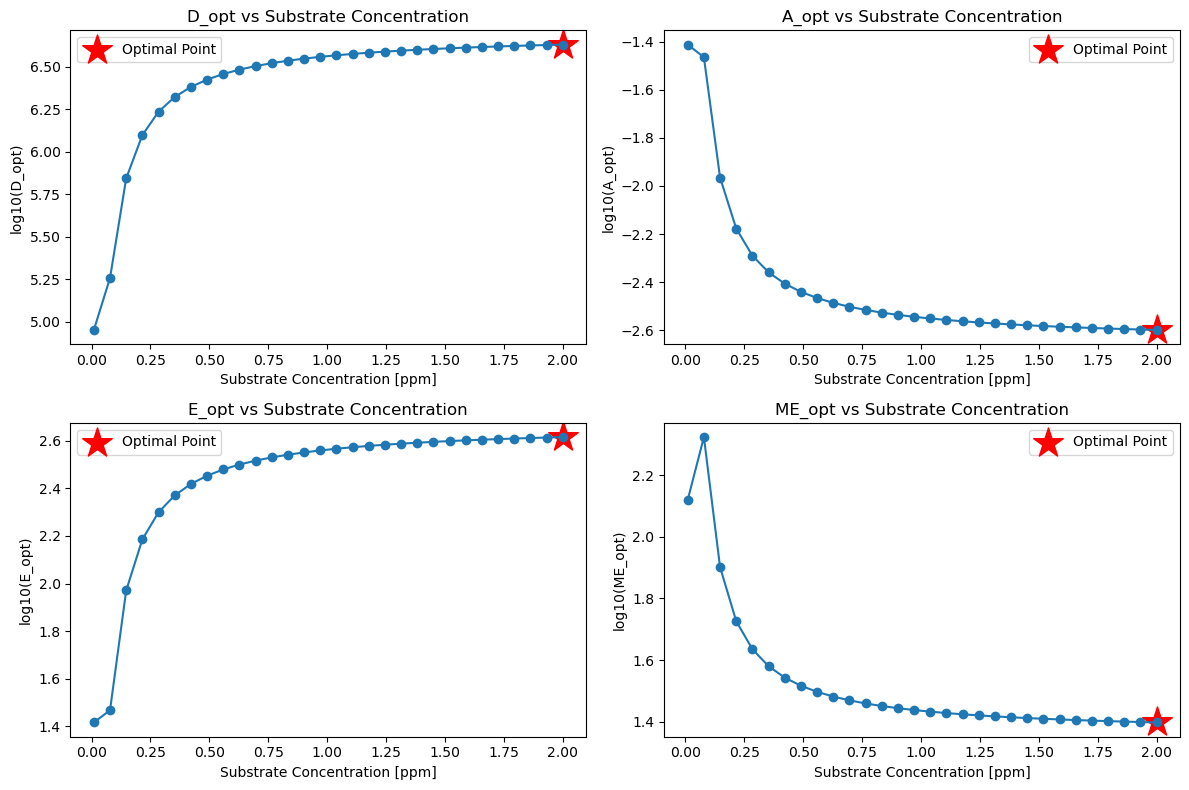

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
metrics_name = ["D_opt", "A_opt", "E_opt", "ME_opt"]
subs_conc_array = np.array(FIM_metric["substrate concentration"])
star_values = [
    (subs_conc_array[np.argmax(FIM_metric["D_opt"])], np.max(FIM_metric["D_opt"])),
    (subs_conc_array[np.argmin(FIM_metric["A_opt"])], np.min(FIM_metric["A_opt"])),
    (subs_conc_array[np.argmax(FIM_metric["E_opt"])], np.max(FIM_metric["E_opt"])),
    (subs_conc_array[np.argmin(FIM_metric["ME_opt"])], np.min(FIM_metric["ME_opt"])),
]
for i in range(4):
    print(f"Star value for metric {metrics_name[i]}: {star_values[i]}")
for i, metric in enumerate(metrics_name):
    ax = axes[i // 2, i % 2]
    ax.plot(subs_conc_array, FIM_metric[metric], marker='o')
    ax.scatter(
        star_values[i][0],
        star_values[i][1],
        color='red',
        marker='*',
        s=500,
        label='Optimal Point',
    )
    ax.set_title(f"{metric} vs Substrate Concentration")
    ax.set_xlabel("Substrate Concentration [ppm]")
    ax.set_ylabel(f"log10({metric})")
    ax.legend()
plt.tight_layout()

In [65]:
import pyomo.environ as pyo

# Create a ReactorVelocity object for each experiment
experiment = ReactionVelocity(data[0], theta_initial=theta_initial)
# model = experiment.get_labeled_model()
# solver = pyo.SolverFactory('ipopt')
# solver.solve(model, tee=True)
scale_nominal_param_value = True
doe_obj = DesignOfExperiments(
    experiment,
    step=0.01,
    scale_nominal_param_value=scale_nominal_param_value,
    objective_option="determinant",
    prior_FIM=FIM,
    tee=True,
)
doe_obj.run_doe()

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [66]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'FIM': [[np.float64(11121.149154050405), np.float64(-1264.8527493196802)],
  [np.float64(-1264.8527493196802), np.float64(618.9157798732143)]],
 'Sensitivity Matrix': [[np.float64(206.77791457488726),
   np.float64(-0.6031731626519717)]],
 'Experiment Design': [19.999973639398622],
 'Experiment Design Names': ['x'],
 'Experiment Outputs': [208.8456937206329],
 'Experiment Output Names': ['reaction_velocity'],
 'Unknown Parameters': [np.float64(1.04728340434887),
  np.float64(1.1702158334470611)],
 'Unknown Parameter Names': ['theta_1', 'theta_2'],
 'Measurement Error': [208.8456937206329],
 'Measurement Error Names': ['reaction_velocity'],
 'Prior FIM': [[np.float64(2569.7279628625297),
   np.float64(-1239.908171579537)],
  [np.float64(-1239.908171579537), np.float64(618.8430163003859)]],
 'Objective express

# RUN 2
Computer experiment data

In [1]:
subs_conc = np.array([0.02, 0.06, 1.5])
rxn_rate = michaelis_menten_model_data(subs_conc)
rxn_rate

NameError: name 'np' is not defined

In [92]:
# Organizing the data in a ``list`` consisting of ``dict``s of ``one key : one value``
data_treated = [
    {"substrate_concentration": sc, "avg_velocity": rr}
    for sc, rr in zip(subs_conc, rxn_rate)
]

Parmest

In [93]:
exp_list = []  # list to hold each experiment
n_exp = len(data_treated)

# exp_list to separate each experiment
for i in range(n_exp):
    exp_list.append(ReactionVelocity(data_treated[i],))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, obj_function="SSE", tee=True)

# Estimating d
obj, theta = pest.theta_est()

# ``parmest`` can mess up the order of the theta estimates and also the covariance. So we need to fix the order so that we can manipulate it properly.
t_order = ["theta_1", "theta_2"]
theta_perm = theta.loc[t_order]  # ``theta`` in the order we want

print("\ntheta values:")
print(theta_perm)

print("\nSSE value: ", obj)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

DOE

In [94]:
theta_initial = {1: theta_perm["theta_1"], 2: theta_perm["theta_2"]}
data = data_treated

In [95]:
FIM_3 = run_reactor_doe(data, n_exp, theta_initial)
FIM_3

array([[9.77e+03, -1.41e+03],
       [-1.41e+03, 5.82e+02]])

In [96]:
# Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(FIM_3)
np.set_printoptions(suppress=False, formatter={'float': '{:.2e}'.format})
print("\nEigenvalues of the FIM:\n", eigenvalues)
np.set_printoptions(precision=2, suppress=False)
print("\nEigenvectors of the FIM:\n", eigenvectors)


Eigenvalues of the FIM:
 [9.98e+03 3.71e+02]

Eigenvectors of the FIM:
 [[ 0.99  0.15]
 [-0.15  0.99]]


In [97]:
cov_doe_3 = np.linalg.inv(FIM_3)
# np.set_printoptions(precision=3, suppress=False)
np.set_printoptions(suppress=False, formatter={'float': '{:.2e}'.format})
print("\nCov of the Experiment using ``DOE``\n", cov_doe_3)


Cov of the Experiment using ``DOE``
 [[1.57e-04 3.80e-04]
 [3.80e-04 2.64e-03]]


In [ ]:
factorial_design = np.linspace(0.01, 2, 30)
FIM_metric = {
    "substrate concentration": [],
    "D_opt": [],
    "A_opt": [],
    "E_opt": [],
    "ME_opt": [],
}
for subs_c in factorial_design:
    exp_sens = ReactionVelocity(
        data={"substrate_concentration": subs_c, "avg_velocity": None},
        theta_initial=theta_initial,
    )
    doe_sens = DesignOfExperiments(exp_sens, scale_nominal_param_value=False, prior_FIM=FIM_3, tee=True)
    FIM_ff = doe_sens.compute_FIM()
    FIM_metric["substrate concentration"].append(subs_c)

    # compute FIM metric
    D_opt, A_opt, E_opt, ME_opt = compute_fim_metric(FIM=FIM_ff)
    FIM_metric["D_opt"].append(D_opt)
    FIM_metric["A_opt"].append(A_opt)
    FIM_metric["E_opt"].append(E_opt)
    FIM_metric["ME_opt"].append(ME_opt)

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Star value for metric D_opt: (np.float64(20.0), np.float64(6.926816899799047))
Star value for metric A_opt: (np.float64(20.0), np.float64(-2.66083556571274))
Star value for metric E_opt: (np.float64(20.0), np.float64(2.67204115982072))
Star value for metric ME_opt: (np.float64(0.01), np.float64(1.3691994993129126))


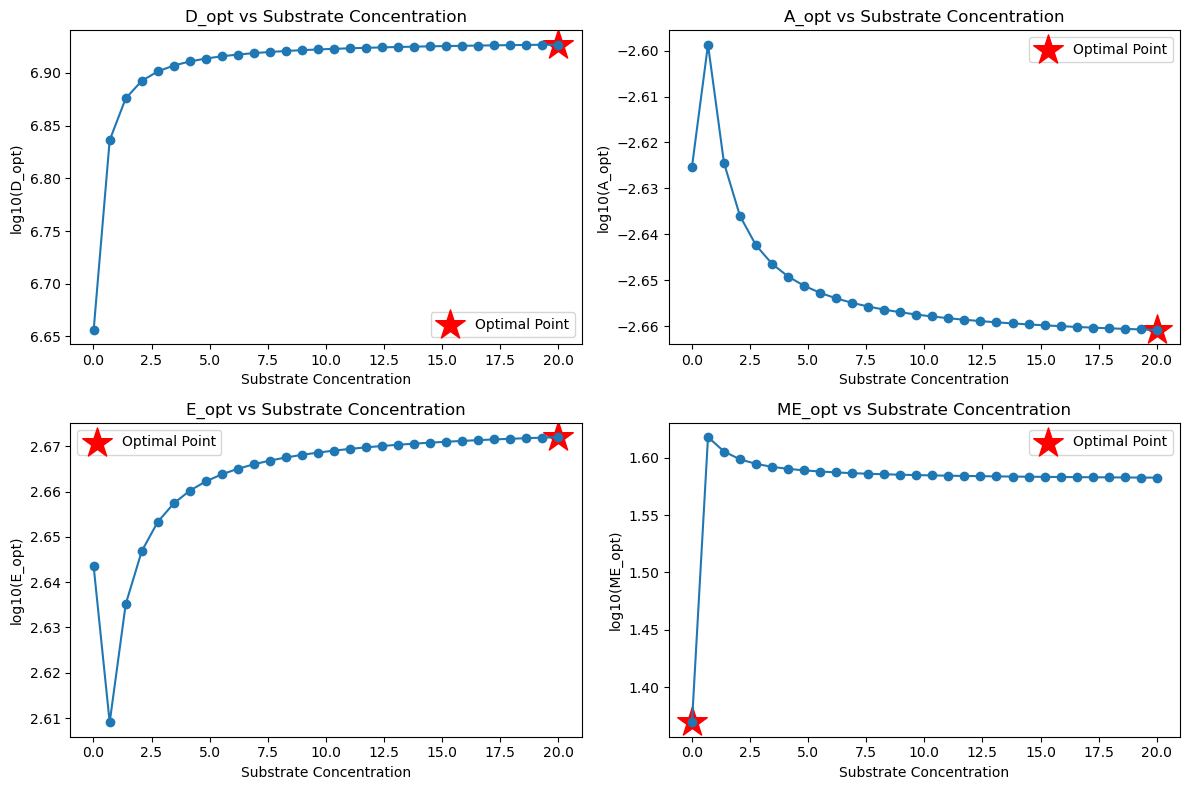

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
metrics_name = ["D_opt", "A_opt", "E_opt", "ME_opt"]
subs_conc_array = np.array(FIM_metric["substrate concentration"])
star_values = [
    (subs_conc_array[np.argmax(FIM_metric["D_opt"])], np.max(FIM_metric["D_opt"])),
    (subs_conc_array[np.argmin(FIM_metric["A_opt"])], np.min(FIM_metric["A_opt"])),
    (subs_conc_array[np.argmax(FIM_metric["E_opt"])], np.max(FIM_metric["E_opt"])),
    (subs_conc_array[np.argmin(FIM_metric["ME_opt"])], np.min(FIM_metric["ME_opt"])),
]
for i in range(4):
    print(f"Star value for metric {metrics_name[i]}: {star_values[i]}")

for i, metric in enumerate(["D_opt", "A_opt", "E_opt", "ME_opt"]):
    ax = axes[i // 2, i % 2]
    ax.plot(subs_conc_array, FIM_metric[metric], marker='o')
    ax.scatter(star_values[i][0],star_values[i][1], color='red', marker='*', s=500, label='Optimal Point')
    ax.set_title(f"{metric} vs Substrate Concentration")
    ax.set_xlabel("Substrate Concentration")
    ax.set_ylabel(f"log10({metric})")
    ax.legend()
plt.tight_layout()

In [61]:
FIM_metric["D_opt"]

[np.float64(6.59075123265643),
 np.float64(6.804819821762102),
 np.float64(6.776881754485546),
 np.float64(6.768178674070317),
 np.float64(6.773279764215792),
 np.float64(6.783158591887616),
 np.float64(6.793938975140447),
 np.float64(6.804205175668606),
 np.float64(6.813519317231015),
 np.float64(6.821815522623447),
 np.float64(6.829161417853165),
 np.float64(6.8356644238696065),
 np.float64(6.841435535659479),
 np.float64(6.846576285191307),
 np.float64(6.851175081516954),
 np.float64(6.855307240100338),
 np.float64(6.859036328369378),
 np.float64(6.862415844466914),
 np.float64(6.865490839371122),
 np.float64(6.868299346682024),
 np.float64(6.870873591240874),
 np.float64(6.87324099003394),
 np.float64(6.8754249729424926),
 np.float64(6.877445653069307),
 np.float64(6.8793203738756885),
 np.float64(6.881064156407497),
 np.float64(6.88269006583217),
 np.float64(6.884209512876682),
 np.float64(6.885632502688682),
 np.float64(6.886967841138696)]

In [29]:
experiment = ReactionVelocity(data[0], theta_initial=theta_initial,)
model = experiment.get_labeled_model()
solver = pyo.SolverFactory('ipopt')
solver.solve(model, tee=True)
scale_nominal_param_value = True
doe_obj = DesignOfExperiments(
    experiment,
    step=0.01,
    scale_nominal_param_value=scale_nominal_param_value,
    objective_option="determinant",
    prior_FIM=FIM_3,
    tee=True,
)
doe_obj.run_doe()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [30]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'FIM': [[np.float64(18612.933366745678), np.float64(-1612.7352657148808)],
  [np.float64(-1612.7352657148808), np.float64(585.8950763850295)]],
 'Sensitivity Matrix': [[np.float64(208.47020300971886),
   np.float64(-6.299461186487652)]],
 'Experiment Design': [1.9999995411656561],
 'Experiment Design Names': ['x'],
 'Experiment Outputs': [210.55490503981423],
 'Experiment Output Names': ['reaction_velocity'],
 'Unknown Parameters': [np.float64(1.085578043529056),
  np.float64(1.2463641556331189)],
 'Unknown Parameter Names': ['theta_1', 'theta_2'],
 'Measurement Error': [210.55490503981423],
 'Measurement Error Names': ['reaction_velocity'],
 'Prior FIM': [[np.float64(9920.968258162997),
   np.float64(-1350.0852752350957)],
  [np.float64(-1350.0852752350959), np.float64(577.9584341370166)]],
 'Objective expr

# Plotting
In this section, we will only use our original model (the one without the reparameterization)

## Plot with regression values
Let's visualize our fit

In [64]:
vel = lambda sub_conc, theta: theta.loc["theta_1"] * sub_conc / ( theta.loc["theta_2"] + sub_conc)

sub_c = np.linspace(data_f["substrate_concentration"][0], data_f["substrate_concentration"][-1], 30)

plt.figure(figsize=(10, 6))
# treated data
plt.scatter(substrate_concentration, treated_avg_velocity, color = "blue", label = 'Treated Velocity')
plt.plot(sub_c, vel(sub_c, theta), lw =3, ls ="--", color = "blue", 
         label=(rf'Treated Velocity-regression ($\hat\theta_1$ ={theta.loc["theta_1"] : 0.3f}, $\hat\theta_2$ ={theta.loc["theta_2"]: 0.3f})'))

# untreated data
plt.scatter(substrate_concentration, untreated_avg_velocity, color = "red", label = 'Untreated Velocity')
plt.plot(sub_c, vel(sub_c, theta_u), lw =3, ls ="--", color = "red", 
         label=(rf'Untreated Velocity-regression ($\hat\theta_1$ ={theta_u.loc["theta_1"] : 0.3f}, $\hat\theta_2$ ={theta_u.loc["theta_2"]: 0.3f})'))
plt.xlabel("Substrate Concentration (ppm)")
plt.ylabel("Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()
plt.title("Reaction velocity vs substrate concentration plot with fitted parameters")

NameError: name 'data_f' is not defined

## Confidence Region
The following sections used only treated velocity. Untreated velocity was not used. Since we can do that simpy by changing the data. The process stays the same.

Text(0.5, 1.0, 'Treated Fit with Confidence Band')

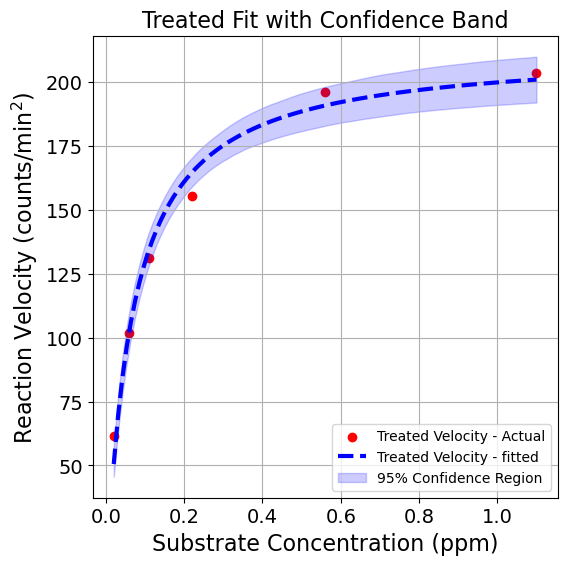

In [ ]:
CI = 95  # The confidence interval 

# Converting pd DF to numpy nd array
cov_n = cov_perm.to_numpy()
theta_n = theta_perm.to_numpy()

# Calculate the standard errors (square root of diagonal elements of covariance matrix)
perr = np.sqrt(np.diag(cov_n))  

# Our model equation
rxn_vel = lambda sub_conc, theta_p: theta_p[0] * sub_conc / ( theta_p[1] + sub_conc)

# Generate confidence bounds using Monte Carlo sampling
n_samples = 1000  # number of parameter samples
# Create random synthetic data points using our theta as mean and covariance as the covariance
theta_samples = np.random.multivariate_normal(theta_n, cov_n, size = n_samples)

# Generate fitted curves for each sampled parameter set
# create some data point's from our substrate concentration
S_range = np.linspace(min(data_f["substrate_concentration"]), max(data_f["substrate_concentration"]), 100)
# Use those data points and the Monte Carlo theta_samples to create 1000 data points (shape: 1000*100)
predicted_curves = np.array([rxn_vel(S_range, theta_val) for theta_val in theta_samples])

# Compute the confidence band
lower_bound = np.percentile(predicted_curves, 100 - CI, axis=0)  # lower bound of the band
upper_bound = np.percentile(predicted_curves, CI, axis=0)  # upper bound of the band

# Plot the 95% inference band
plt.figure(figsize=(6,6))
plt.scatter(data_f["substrate_concentration"], data_f["treated_avg_velocity"], color = "red", label = "Treated Velocity - Actual")
plt.plot(S_range, rxn_vel(S_range, theta_n), lw =3, ls ="--", color = "blue", label="Treated Velocity - fitted")
plt.fill_between(S_range, lower_bound, upper_bound, color = "blue", alpha=0.2, label=f"{CI}% Confidence Region")
plt.xlabel("Substrate Concentration (ppm)")
plt.ylabel("Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()
plt.title("Treated Fit with Confidence Band")

From the confidence band we can see that the estimation is excellent at low substrate concentration, and it gets worse with increase in substrate concentration.

## Joint parameter confidence region (Confidence Ellipsoid)
Now lets draw a joint confidence ellipsoid to visualize our parameter uncertainty. We will use the eigen values of our parameter covariance matrix in combination with $\chi$ value to determine the length of the axes of our ellipsoid, and use the eigen vectors to set the angle of our ellipsoid.

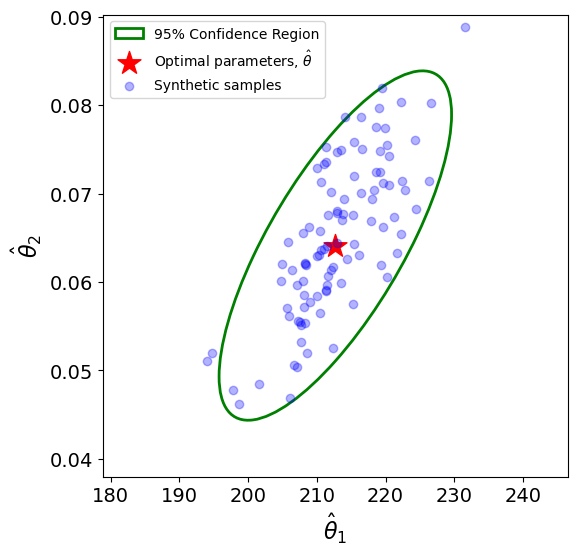

In [ ]:
import scipy.stats as stat
from matplotlib.patches import Ellipse

CI = 95  # The confidence interval 

# Calculate the eigen values and eigen vectors. 
eigvals, eigvecs = np.linalg.eigh(cov_n)
order = eigvals.argsort()[::-1]  # returns the descending order index of the eigen values.
eigvals, eigvecs = eigvals[order], eigvecs[:, order]  # reorder

# Define angle and width/height of the ellipse
chi2_val = stat.chi2.ppf(CI/100, df=2)  # Chi-square value for %CI, df -> 2 degrees of freedom (two parameters)
scale_factor = np.sqrt(chi2_val)
width, height = 2 * scale_factor * np.sqrt(eigvals)  # scaling for 95% Cofidence
angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0]) * 180 / np.pi

# Plot the confidence ellipse
fig, ax = plt.subplots(figsize=(6, 6))

# Create the ellipse object
ellipse = Ellipse(xy=theta_n, width=width, height=height, angle=angle, facecolor='none', edgecolor="green", lw=2, label=f"{CI}% Confidence Region")
ax.add_patch(ellipse)

# add labels and formatting
ax.set_xlabel(r"$\hat\theta_1$")
ax.set_ylabel(r"$\hat\theta_2$")
ax.scatter(theta_n[0], theta_n[1], color="red", marker="*", s=300, label = r"Optimal parameters, $\hat\theta$")
# Set proper limits based on ellipse size
ax.set_xlim(theta_n[0] - width, theta_n[0] +  width)
ax.set_ylim(theta_n[1] - height, theta_n[1] + height)

# To plot some random synthetic data points using Monte Carlo sampling for our optimum theta.
# In reality our theta value could be any of these random points.
n_samples = 100  # number of scatter points we want to plot
np.random.seed(101)
theta_samples = np.random.multivariate_normal(theta_n, cov_n, size = n_samples)
ax.scatter(theta_samples[:, 0], theta_samples[:, 1], color='blue', alpha=0.3, label="Synthetic samples")
ax.legend()

# Scipy
We will now use `scipy` to calculate the parameters and the parameter covariance matrix

In [ ]:
# Data
substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
treated_velocity = np.array([
    [76, 47], 
    [97, 107], 
    [123, 139], 
    [159, 152], 
    [191, 201], 
    [207, 200]])

treated_avg_velocity = np.nanmean(treated_velocity, axis = 1)

In [ ]:
from scipy.optimize import minimize, curve_fit

In [ ]:
def rxn_vel(x, theta_1, theta_2):  # ``curve_fit`` expects the parameters to be separate arguments and independet variable should be the first argument
    return theta_1 * x / (theta_2 + x)
    
def SSE(theta, x, y):  # the minimizer variable should be passed in as the first argument and as a vector.
    y_pred = theta[0] * x / (theta[1] + x)
    return np.sum((y - y_pred)**2)

## Scipy Minimize

In [ ]:
theta_initial = [200, 0.05]
result = minimize(SSE, theta_initial, args=(substrate_concentration, treated_avg_velocity), method="Nelder-Mead")
# ``args `` -> the extra parameters that should be passed in the objective function. 
# In this case, x -> substrate_concentration and y -> treated_avg_velocity
print('fitted parameters using scipy minimize:', result.x)

fitted parameters using scipy minimize: [2.12683777e+02 6.41213441e-02]


## Curve fit

In [ ]:
sig_cf = 0.03  # measurement error
popt, pcov = curve_fit(rxn_vel, substrate_concentration, treated_avg_velocity, absolute_sigma=True, sigma=sig_cf, p0=(200, 0.05))
print("theta[1] = ", popt[0])
print("theta[2] = ", popt[1])
theta_names = ['theta[1]', 'theta[2]']
pcov = pd.DataFrame(pcov, index=theta_names, columns=theta_names)
print('covariance matrix\n', pcov)

theta[1] =  212.68372727015148
theta[2] =  0.06412125694366122
covariance matrix
               theta[1]      theta[2]
theta[1]  7.266987e-04  6.627282e-07
theta[2]  6.627282e-07  1.032521e-09


## Least squares

In [ ]:
from scipy import stats, optimize

In [ ]:
# Define the regression model
def reg_fit(theta, x):  
    yhat = theta[0] * x / (theta[1] + x)
    return yhat

# define the residuals
def residuals(theta, x, y): # the parameters must be vector for scipy least squares and passed as the first argument
    e = y - reg_fit(theta, x)
    return e

In [ ]:
# actual data
n_exp = len(treated_avg_velocity)
x = np.array(substrate_concentration)
y_ac = np.nanmean(treated_velocity, axis = 1)  
y_ac += np.random.normal(scale=0.03, size=n_exp)  # add a random noise to the measurement data

# initial guess of the parameters
theta0 = np.array([200, 0.05])

# bounds
bnds = ([0, 0], [np.inf, np.inf])

# least squares regression
sc_results = optimize.least_squares(residuals, theta0, bounds=bnds, args=(x, y_ac))

theta = sc_results.x
print('parameter values using least squares', theta)

parameter values using least squares [2.12683044e+02 6.40828158e-02]


### Uncertainty analysis (Covariance matrix)
Now least squares will be used to calculate the uncertainty of our parameters

In [ ]:
jaco = sc_results.jac  # jacobian of the cost function 
er = sc_results.fun  # sc_results.fun is actually the residual at our optimized theta values

# Calculate the variance of measurement error (noise)
sig2re = 0.03**2 # (er.T @ er) / (len(er) - 2)  # 2 is the number of parameters
# If we don't know the value of sigma^2 for measurement error, we use this formula, otherwise we use the measurent error as sig2re

# Calculate the covariance matrix of the parameters
cov_ls = sig2re * np.linalg.inv(jaco.T @ jaco)
print("\nCov of theExperiment using ``Least Squares``\n", cov_ls)


Cov of theExperiment using ``Least Squares``
 [[7.26418123e-04 6.62162305e-07]
 [6.62162305e-07 1.03127029e-09]]


From scipy `curve_fit`and `least_squares` we can see that they both gave us the almost same parameter values and almost same covariance matrix. 

#  Monte Carlo Uncertainty analysis
In Monte Carlo uncertainty analysis,  
    -> **First**, we will use the given decision variable values (substrate concentration in ths case) to get the model predictions  
    -> **Second**, we will generate 1000 (or any other number) normally distributed random measurement error by using the given measurement error as the standard deviation.  
    -> **Third**, add the predictions with the generated measurement error,  
    -> **Fourth**, we will then use those predictions (with measurement error) and the given decision variable values  to fit 1000 pair of parameter values.  
    -> **Last**, we will calculate the parameter covariance of our 1000 fitted parameter values


## Generating random error and adding that to predictions

In [ ]:
substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
theta_p = theta_perm.to_numpy()  # use the fitted parameter values
rxn_vel_mc = lambda sub_conc: theta_p[0] * sub_conc / ( theta_p[1] + sub_conc)
model_pred = rxn_vel_mc(substrate_concentration)  # model predictions for the ``substrate_concentration``
measurement_err = 0.03  # measurement error
n_exp = len(model_pred)

# for loop for mc sampling
mc_s = []  # empty list for our ``response`` with ``measurement error``
n_mc = 1000  # number of monte carlo sample points
np.random.seed(101)
for i in range(n_mc):
    random_err = stats.norm.rvs(scale=measurement_err, size=n_exp)   # random variates of the given size
    pred_w_err = model_pred + random_err  # adding random error to our model predictions
    mc_s.append(pred_w_err)    

## Parameter covariance matrix


In [ ]:
# exp_list to separate each experiment
t_order = ["theta_1", "theta_2"]  # the order of ``theta`` we want
col_names = ["substrate_concentration", "avg_velocity"]
theta_values = np.zeros((n_mc, 2))

import time
start_time = time.time()  # Start timer

for i in range(n_mc):  # this for loop can be merged with the for loop in  the cell above
    vel_mc = mc_s[i]
    # veritcally stacking the ``substrate_concentration`` and our predicted velocity w/ measurement error
    data_con = np.vstack((substrate_concentration, mc_s[i])).T   
    df = pd.DataFrame(data_con, columns=col_names)

    exp_list = []
    for j in range(n_exp):
        exp_list.append(ReactionVelocity(df.iloc[j]))

    # Creating an Estimator object
    pest = parmest.Estimator(exp_list, tee = False)  
    
    # obj, theta = pest.theta_est()
    obj, theta = pest.theta_est()
    theta_ordered = theta.loc[t_order].to_numpy()
    theta_values[i, :] = theta_ordered


end_time = time.time()   
print(f"Execution time: {end_time - start_time: 0.6f} seconds")  

Execution time:  26.318619 seconds


In [ ]:
# Calculating Covariance matrix using MC
cov_mc = np.cov(theta_values, rowvar=False)
cov_mc

array([[7.91094359e-04, 7.14627770e-07],
       [7.14627770e-07, 1.05901655e-09]])

# Covariance matrix using different packages
Let's now compare the covariance matrix we got from using different methods / packages

In [ ]:
print("Cov of the Experiment using SciPy ``Curve Fit``:\n", pcov)
print("\nCov of the Experiment using ``Least Squares``\n", cov_ls)
print("\nCov of the Experiment using ``ParmEst``\n", cov_perm)
print("\nCov of the Experiment using ``DOE``\n", cov_doe)
print("\nCov of the Experiment using ``Monte Carlo``\n", cov_mc)

Cov of the Experiment using SciPy ``Curve Fit``:
               theta[1]      theta[2]
theta[1]  7.266987e-04  6.627282e-07
theta[2]  6.627282e-07  1.032521e-09

Cov of the Experiment using ``Least Squares``
 [[7.26418123e-04 6.62162305e-07]
 [6.62162305e-07 1.03127029e-09]]

Cov of the Experiment using ``ParmEst``
            theta_1   theta_2
theta_1  47.672886  0.041806
theta_2   0.041806  0.000065

Cov of the Experiment using ``DOE``
 [[6.19677823e-04 6.05567261e-07]
 [6.05567261e-07 1.06057621e-09]]

Cov of the Experiment using ``Monte Carlo``
 [[7.91094359e-04 7.14627770e-07]
 [7.14627770e-07 1.05901655e-09]]


## Calculating the ratios of covariance matrix computed by different packages / methods

### Least squares / Curve fit

In [ ]:
cov_ls / pcov

,theta[1],theta[2]
theta[1],0.999614,0.999146
theta[2],0.999146,0.998789


### DOE / Curve Fit

In [ ]:
cov_doe / pcov

,theta[1],theta[2]
theta[1],0.852730,0.913749
theta[2],0.913749,1.027171


### Monte Carlo / Curve fit

In [ ]:
cov_mc / pcov

,theta[1],theta[2]
theta[1],1.088614,1.078312
theta[2],1.078312,1.025661


### Parmest / Curve fit

In [ ]:
cov_perm.to_numpy() / pcov

,theta[1],theta[2]
theta[1],65601.998791,63081.949101
theta[2],63081.949101,63082.050235


We can see that the values of scipy `curve_fit` and `minimize` are almost identical, `Monte Carlo` and `DOE` are very close. However, `Parmest` is very bad, because parmest doesn't consider mesurement error during calculating the covariance matrix. So the result it shows is basically just using the input and output w/o any measurement error.
The parameter covariance matrix depends on `measurement error`, but `parameter values` do not depend on it. Therefore, we got almost same parameter values across all packages and methods while using `SSE` as the objective

# Reparameterized model
## Generate data

In [ ]:
true_beta = np.array([0.006, 0.0003])

In [ ]:
def inv_rxn_rate(substrate_conc, true_parameters=true_beta):
    return true_parameters[0] + (true_parameters[1] / substrate_conc) + np.random.normal(0, 0.0001)

In [ ]:
inv_rr = inv_rxn_rate(subs_conc)

In [ ]:
class ReactionVelocity_wrp(Experiment):

    # Defining the constructor for our model
    def __init__(self, data, beta_initial=None,scale_params=True):
        """
        Arguments:
            data: data from our experiment. type: 'dict'
            beta_initial: initial guess of the parameter values, dtype: dict. pass the values as beta_initial = {1 : <beta_1 initial value>, 2 : <beta_2 initial value>}
                default:  {1: 0.0047, 2: 0.0003}
                
        """
        self.conc = data["substrate_concentration"]
        self.vel = data["avg_velocity"]
        self.model = None
        self.beta_initial = beta_initial
        if self.beta_initial is None:
            self.beta_initial = {1: 0.0047, 2: 0.0003}  # default initial guess of beta[1] & beta[2]
        else:
            self.beta_initial = beta_initial

        if scale_params:
            self.beta_1_scale = 0.005
            self.beta_2_scale = 0.0002
        else:
            self.beta_1_scale = 1
            self.beta_2_scale = 1

    # Creating the get_labeled_model which is a must for ``DOE`` and ``ParmEst``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
            self.finalize_model()
        return self.model

    
    def create_model(self):
        """
        Here, we will create different variables, parameters, and constraints
        """
        m = self.model = pyo.ConcreteModel()

        # beta_1
        m.beta_1 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.beta_initial[1])
        m.beta_2 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.beta_initial[2])

        # substrate concentration (x) as a param, since the data is given          
        m.u = pyo.Var(domain = pyo.NonNegativeReals, initialize = (1 /self.conc))  # 1/substrate concentration
        m.reaction_velocity_inv = pyo.Var(domain = pyo.NonNegativeReals)  # 1/reaction_velocity

        # reaction_velocity = f(substrate_concentration, beta), is obtained from this equation.
        # So we will set it as an ``Expression``
        # m.reaction_velocity = pyo.Expression(expr = m.beta[1] * m.x / (m.beta[2] + m.x))        
        @m.Constraint()  # since the ``Constraint`` is not a set of anything, so there is no argument
        def vel_con(m):
            return m.reaction_velocity_inv == m.beta_1*self.beta_1_scale + m.beta_2 *self.beta_2_scale * m.u

        return m

    
    def finalize_model(self):
        """
        Finalizing the model. Here, we will set the experimental conditions (e.g, initial conditions),
        fixing the parameter values (if needed), update `t` values, and discretize the model (if model is dynamic). 
        It makes a solvable model.
        """        
        m=self.model

        # fixing the parameters
        m.beta_1.fix(self.beta_initial[1]) 
        m.beta_2.fix(self.beta_initial[2]) 

        # Add lower and upper bound to substrate concentration (control variable)
        m.u.setlb(0)
        m.u.setub(1000)

        # fixing the substrate concentration (control variable)
        m.u.fix(1/self.conc)

        return m

    
    def label_model(self):
        """
        The model is updated with outputs, and unknown parameters. This makes the model labeled with full experiment.
        In `ParmEst` output (given data) is the most important. For `DOE` input is most important.
        """
        m = self.model

        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)  
        m.experiment_outputs.update([(m.reaction_velocity_inv, 1/self.vel)])  # Pass the data as a list of `tuple`
        # If we only use ``DOE``, we could use ``m.experiment_ouputs.update([(m, None)])``.
        # Output is not important for ``DOE``

        m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)    
        # m.experiment_inputs[m.x] = self.conc
        m.experiment_inputs.update([(m.u, None)])
        # We have only defined the input in m.u.fix(1/self.conc), so we won't update it. even if we update it here, parmest and doe won't consider this value.

        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.beta_1, m.beta_2])
        # m.unknown_parameters[m.beta_1]= self.beta_initial[1]
        # m.unknown_parameters[m.beta_2]= self.beta_initial[2]

        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # m.measurement_error[m.reaction_velocity] = 0.03
        m.measurement_error.update([(m.reaction_velocity_inv, 0.0001)])  # variance of the measurement error, b/c in doe, the measurement error is passed as variance, not std
        # this will be fixed in later update 

        return m

In [ ]:
exp_list = []
conc = np.array([0.02, 2, 0.001])
vel = 1/inv_rxn_rate(conc)
n_exp = len(conc)
data_treated = [
    {"substrate_concentration": sc, "avg_velocity": rr} for sc, rr in zip(conc, vel)
]
# exp_list to separate each experiment
for i in range(n_exp):
    exp_list.append(ReactionVelocity_wrp(data_treated[i]))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, tee=False, obj_function="SSE")

# Estimating d
obj_b, beta= pest.theta_est( cov_n=n_exp)

# ``parmest`` can mess up the order of the theta estimates and also the covariance. So we need to fix the order so that we can manipulate it properly.
b_order = ["beta_1", "beta_2"]
beta_perm = beta.loc[b_order]  # ``theta`` in the order we want

print("\nbeta values:")
print(beta_perm)

print("\nSSE value: ", obj_b)


beta values:
beta_1    1.213295
beta_2    1.499991
dtype: float64

SSE value:  1.847745098288463e-12


In [ ]:
beta_initial = {1: beta_perm["beta_1"], 2: beta_perm["beta_1"]}
data = data_treated

In [ ]:
def run_reactor_doe(data, n_exp, beta_initial):
    FIM = []
    for i in range(n_exp):
        # Create a ReactorVelocity object for each experiment
        experiment = ReactionVelocity_wrp(data[i], beta_initial=beta_initial)

        scale_nominal_param_value = False
        doe_obj = DesignOfExperiments(
            experiment, scale_nominal_param_value=scale_nominal_param_value, tee=False
        )
        # I haven't passed the other arguments, because the defaults values are used in the doe example.

        FIM.append(doe_obj.compute_FIM())

    # Let's sum up the FIM to get the total FIM of all the experiments and then use that FIM as a prior_FIM in `compute_FIM_full_factorial()`
    FIM_prior = np.array(FIM).sum(axis=0)
    return FIM_prior

In [ ]:
FIM = run_reactor_doe(data, n_exp, beta_initial)
cov_doe = np.linalg.inv(FIM)
# np.set_printoptions(precision=2, suppress=False)
print(f"FIM for {n_exp} experiments\n", FIM)
print("\nCov of the Experiment using ``DOE``\n", cov_doe)

FIM for 3 experiments
 [[  0.75  10.5 ]
 [ 10.5  401.  ]]

Cov of the Experiment using ``DOE``
 [[ 2.11 -0.06]
 [-0.06  0.  ]]


In [ ]:
# Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(FIM)
print("\nEigenvalues of the FIM:\n", eigenvalues)
print("\nEigenvectors of the FIM:\n", eigenvectors)


Eigenvalues of the FIM:
 [  0.47 401.28]

Eigenvectors of the FIM:
 [[-1.   -0.03]
 [ 0.03 -1.  ]]


In [ ]:
factorial_design = np.linspace(0.001, 2, 30)
FIM_metric = {
    "substrate concentration": [],
    "D_opt": [],
    "A_opt": [],
    "E_opt": [],
    "ME_opt": [],
}
for subs_c in factorial_design:
    exp_sens = ReactionVelocity_wrp(
        data={"substrate_concentration": subs_c, "avg_velocity": 1},
        beta_initial=beta_initial,
    )
    doe_sens = DesignOfExperiments(exp_sens, scale_nominal_param_value=False, tee=True)
    FIM_ff = doe_sens.compute_FIM()
    FIM_metric["substrate concentration"].append(subs_c)

    # compute FIM metric
    D_opt, A_opt, E_opt, ME_opt = compute_fim_metric(FIM=FIM_ff, FIM_prior=FIM)
    FIM_metric["D_opt"].append(D_opt)
    FIM_metric["A_opt"].append(A_opt)
    FIM_metric["E_opt"].append(E_opt)
    FIM_metric["ME_opt"].append(ME_opt)

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Star value for metric D_opt: (np.float64(0.001), np.float64(2.580406105690809))
Star value for metric A_opt: (np.float64(2.0), np.float64(0.1410201874789383))
Star value for metric E_opt: (np.float64(2.0), np.float64(-0.14023727689944826))
Star value for metric ME_opt: (np.float64(2.0), np.float64(2.7436806354712404))


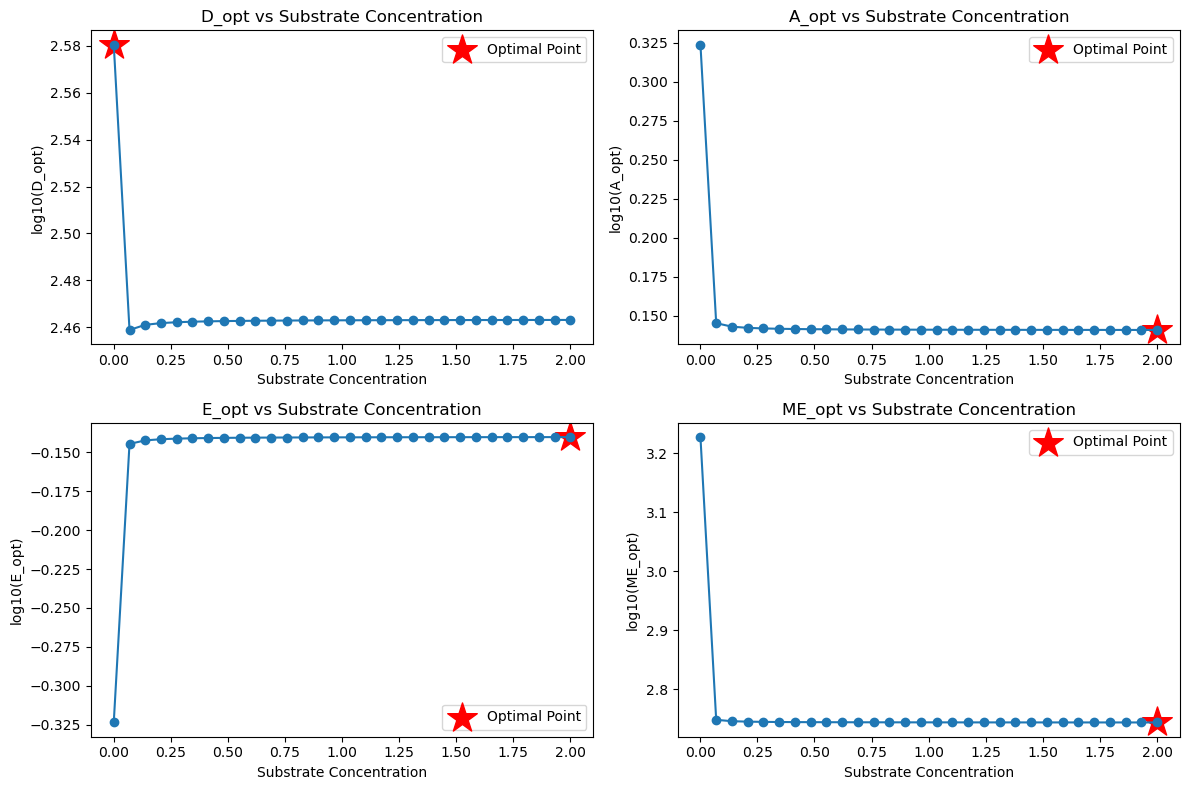

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
metrics_name = ["D_opt", "A_opt", "E_opt", "ME_opt"]
subs_conc_array = np.array(FIM_metric["substrate concentration"])
star_values = [
    (subs_conc_array[np.argmax(FIM_metric["D_opt"])], np.max(FIM_metric["D_opt"])),
    (subs_conc_array[np.argmin(FIM_metric["A_opt"])], np.min(FIM_metric["A_opt"])),
    (subs_conc_array[np.argmax(FIM_metric["E_opt"])], np.max(FIM_metric["E_opt"])),
    (subs_conc_array[np.argmin(FIM_metric["ME_opt"])], np.min(FIM_metric["ME_opt"])),
]
for i in range(4):
    print(f"Star value for metric {metrics_name[i]}: {star_values[i]}")

for i, metric in enumerate(["D_opt", "A_opt", "E_opt", "ME_opt"]):
    ax = axes[i // 2, i % 2]
    ax.plot(subs_conc_array, FIM_metric[metric], marker='o')
    ax.scatter(
        star_values[i][0],
        star_values[i][1],
        color='red',
        marker='*',
        s=500,
        label='Optimal Point',
    )
    ax.set_title(f"{metric} vs Substrate Concentration")
    ax.set_xlabel("Substrate Concentration")
    ax.set_ylabel(f"log10({metric})")
    ax.legend()
plt.tight_layout()